In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
dataset = pd.read_csv(r'/content/imdb_dataset.csv')
# dataset_aug=pd.read_excel('/content/actualbleuimdbpositive.xlsx')
# dataset_aug1=pd.read_excel('/content/actualbleuimdbpositive.xlsx')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1999 non-null   object
 1   sentiment  1999 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [ ]:
dataset_aug.shape

(500, 2)

In [ ]:
dataset_aug= dataset_aug.iloc[:500]
dataset_aug.shape


(500, 2)

In [ ]:
dataset_aug

,sentiment,review
0,positive,new york city of sky games is fantastic . the ...
1,positive,if eagerly hooked up you can see more than onc...
2,positive,short spoilers this is a world that is storyte...
3,positive,william definitely is a games to be one of my ...
4,positive,la des . you know it the best movie for all ag...
...,...,...
495,positive,a movie made by both perils and as powerful as...
496,positive,with such a small cast with superb actors impr...
497,positive,this movie has such a two dimensional step to ...
498,positive,in direction and i mean i ve watched the many ...


In [ ]:
n = 20
df=dataset.head(int(len(dataset)*(n/100)))
# df_negative=dataset[dataset['sentiment']=='negative']
# df.shape
test_reviews = df['review']
test_sentiments = df['sentiment']
df.shape

(399, 2)

In [ ]:
subset_df = df[df["sentiment"] =='negative']

In [ ]:
len(subset_df)

210

In [ ]:
print(test_reviews)

0      One of the other reviewers has mentioned that ...
1      A wonderful little production. <br /><br />The...
2      I thought this was a wonderful way to spend ti...
3      Basically there's a family where a little boy ...
4      Petter Mattei's "Love in the Time of Money" is...
                             ...                        
394    Helena Bonham Carter is the center of this mov...
395    I commented on this when it first debuted and ...
396    Just because someone is under the age of 10 do...
397    "Hey Babu Riba" is a film about a young woman,...
398    After a snowstorm, the roads are blocked and t...
Name: review, Length: 399, dtype: object


In [ ]:
dataset.drop(df.index, axis=0,inplace=True)

In [ ]:
dataset_final=pd.concat([dataset_aug,dataset])

In [ ]:
dataset = dataset_final.sample(frac = 1)

In [ ]:
dataset.shape

(1600, 2)

In [ ]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:1600]
train_sentiments = sentiments[:1600]

# test_reviews = reviews[1600:]
# test_sentiments = sentiments[1600:]

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 399/399 [00:00<00:00, 1653.77it/s]

CPU times: user 1.12 s, sys: 13 ms, total: 1.13 s
Wall time: 1.15 s


In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('toms', 27574), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=27575
Number of Documents=1600


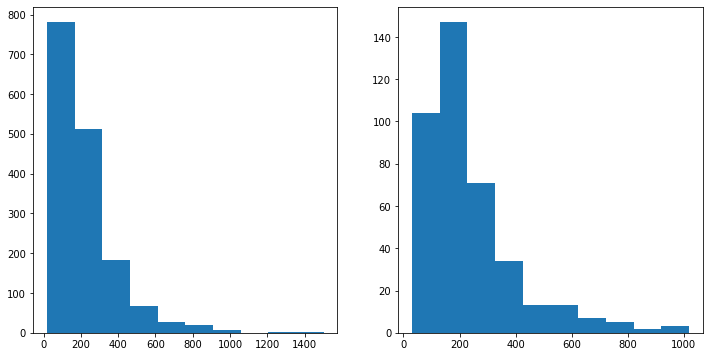

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((1600, 1000), (399, 1000))

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 300)         8272500   
                                                                 
 conv1d_12 (Conv1D)          (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 500, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 500, 64)           32832     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 250, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 250, 32)          

In [ ]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
12/12 [==============================] - 40s 3s/step - loss: 0.6999 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5063
Epoch 2/2
12/12 [==============================] - 38s 3s/step - loss: 0.6916 - accuracy: 0.5104 - val_loss: 0.6943 - val_accuracy: 0.5063


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

13/13 [==============================] - 3s 219ms/step - loss: 0.6961 - accuracy: 0.4737
Accuracy: 47.37%


In [ ]:
# predictions = model.predict_classes(X_test).ravel()
# predictions[:10]

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
print(predictions,model.predict(X_test))
predictions = ['positive' if item == 1 else 'negative' for item in predictions]

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       210
    positive       0.47      1.00      0.64       189

    accuracy                           0.47       399
   macro avg       0.24      0.50      0.32       399
weighted avg       0.22      0.47      0.30       399



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,negative,positive
negative,0,210
positive,0,189
